### Imports

In [1]:
%matplotlib widget
%cd ../../..
import logging
logging.basicConfig(level=logging.INFO)
import os
import re

from linetimer import CodeTimer
import matplotlib.pyplot as plt
import nibabel
from nibabel import processing, nifti1, affines
import numpy as np
from scipy.ndimage import binary_closing
from skimage.metrics import mean_squared_error, normalized_root_mse

from BabelBrain.GPUFunctions.GPUBinaryClosing import BinaryClosing
from BabelBrain.GPUFunctions.GPUResample import Resample

/Users/acoreas/opt/miniconda3/envs/bbl_dev2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/acoreas/Documents/GitHub/BabelBrain
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### GPU Initialization

In [2]:
# GPUBackend = 'CUDA'
# GPUBackend = 'OpenCL'
GPUBackend = 'Metal'
gpu_name = 'Apple M1 Max'

BinaryClosing.InitBinaryClosing(gpu_name, GPUBackend=GPUBackend)
Resample.InitResample(gpu_name, GPUBackend=GPUBackend)

Selecting device:  Apple M1 Max
mc_set_external_gpu 1
Selecting device:  Apple M1 Max
mc_set_external_gpu 1


### Load Input Data

In [3]:
fname = '/Users/acoreas/Documents/BabelBrain Imaging Data/SDR_0p55/CT.nii.gz'
base_name,_ = os.path.splitext(os.path.splitext(fname)[0])
nifti = nibabel.load(fname)
data = nifti.get_fdata()

### Determine Output Data Resolution

In [4]:
# Set desired spatial step
resolution_level = {
    '0': 0.919,    # 200 kHz,   6 PPW
    '1': 0.613,    # 200 kHz,   9 PPW
    '2': 0.459,    # 200 kHz,  12 PPW
    '3': 0.306,    # 600 kHz,   6 PPW
    '4': 0.204,    # 600 kHz,   9 PPW
    '5': 0.153,    # 600 kHz,  12 PPW
    '6': 0.184,    # 1000 kHz,  6 PPW
    '7': 0.123,    # 1000 kHz,  9 PPW
    '8': 0.092,    # 1000 kHz, 12 PPW
}
spatial_step = np.full(3,resolution_level['0'])
# spatial_step = np.asarray(nifti.header.get_zooms())/2
spatial_step_text = re.sub("\.","_",str(spatial_step[0]))

# Calculate new affine
zooms = np.asarray(nifti.header.get_zooms())
print(f"Original zooms: {zooms}")
print(f"New zooms: {spatial_step}")
new_x = int(nifti.shape[0]/(spatial_step[0]/zooms[0]))
new_y = int(nifti.shape[1]/(spatial_step[1]/zooms[1]))
new_z = int(nifti.shape[2]/(spatial_step[2]/zooms[2]))
affine_upscaled = affines.rescale_affine(nifti.affine.copy(),
                                         nifti.shape,
                                         spatial_step,
                                         (new_x,new_y,new_z))

# Output dimensions
output_data = np.zeros((new_x,new_y,new_z),dtype=np.uint8)
output_nifti = nifti1.Nifti1Image(output_data,affine_upscaled)
print(f"Output Dimensions: {output_data.shape}")
print(f"Output Size: {output_data.size}")

Original zooms: [0.44921893 0.449219   0.6255521 ]
New zooms: [0.919 0.919 0.919]
Output Dimensions: (250, 269, 179)
Output Size: 12037750


### Run Resample Step

In [5]:
# Select a resample method
# resample_method = 'CPU' # Truth method, accurate but takes longer especially for higher resolutions
resample_method = 'GPU' # Much faster, but can have slight deviations from truth. Acceptable for purposes of this test.
print(f"Resampling via {resample_method}")

# Set resample order and mode (default is 3 and 'constant')
order = 0
mode = 'constant' #'nearest'

if resample_method == 'CPU':
    # Reload file if it was created already, otherwise generate and save file
    resampled_fname = base_name + f"_resampled_{resample_method}_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
    if os.path.exists(resampled_fname):
        print('Reloading file')
        resampled_nifti = nibabel.load(resampled_fname)
        resampled_data = resampled_nifti.get_fdata()
    else:
        print('Generating file')
        resampled_nifti = processing.resample_from_to(nifti,output_nifti,mode=mode,order=order,cval=data.min()) # Truth method
        print('Saving file')
        nibabel.save(resampled_nifti,resampled_fname)
        print('Collecting data')
        resampled_data=resampled_nifti.get_fdata()
elif resample_method == 'GPU':
    # Generating file is typically faster than reloading a saved file
    print('Generating file')
    resampled_nifti = Resample.ResampleFromTo(nifti,output_nifti,mode=mode,order=order,cval=data.min(),GPUBackend=GPUBackend)
    resampled_data = resampled_nifti.get_fdata()

INFO:root:
Starting Resample


Resampling via GPU
Generating file


INFO:root:Total points: 12037750
INFO:root:Working on slices 0 to 250 out of 250


### Prepare Data

In [6]:
# Check input data is contiguous
if not resampled_data.flags.contiguous:
    print("Changing input data to be a contiguous array")
    resampled_data = np.ascontiguousarray(resampled_data)

HUCapThreshold = 2100.0
HUThreshold = 300.0
resampled_data[resampled_data>HUCapThreshold] = HUCapThreshold
sf2 = np.round((np.ones(3)*5)/resampled_nifti.header.get_zooms()).astype(int)
print(f"sf2: {sf2}")
fct = resampled_data>HUThreshold

sf2: [5 5 5]


### Run Binary Closing Step

In [7]:
with CodeTimer("GPU Binary Closing", unit="s"):
    data_binary_closing_gpu = BinaryClosing.BinaryClose(fct, structure=np.ones(sf2,dtype=int), GPUBackend=GPUBackend)

with CodeTimer("CPU Binary Closing", unit="s"):
    print(f"Starting Binary Closing")
    binary_closing_truth_fname = base_name + f"_binary_closing_CPU_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
    if os.path.exists(binary_closing_truth_fname):
        print("Reloading CPU file")
        data_binary_closing_cpu = nibabel.load(binary_closing_truth_fname).get_fdata()
    else:
        print('Generating CPU file')
        data_binary_closing_cpu = binary_closing(fct,structure=np.ones(sf2,dtype=int))
        nifti_binary_closing_cpu = nibabel.Nifti1Image(data_binary_closing_cpu.astype(np.float32),affine_upscaled)
        print('Saving CPU file')
        nibabel.save(nifti_binary_closing_cpu,binary_closing_truth_fname)

# Ensure arrays are same size and dtype
if data_binary_closing_gpu.size != data_binary_closing_cpu.size:
    print(f"Array sizes don't match: {data_binary_closing_gpu.size} vs {data_binary_closing_cpu.size}")
if data_binary_closing_gpu.size == 0:
    print("Arrays are empty")
if data_binary_closing_gpu.dtype == data_binary_closing_cpu.dtype:
    print("Arrays have different dtypes, changing them to match")
    data_binary_closing_gpu.astype(data_binary_closing_cpu.dtype)

INFO:root:
Starting Binary Closing
INFO:root:Total points: 12037750
INFO:root:
Working on slices 0 to 250 out of 250
INFO:root:Total points: 12037750
INFO:root:
Working on slices 0 to 250 out of 250


Code block 'GPU Binary Closing' took: 0.11993 s
Starting Binary Closing
Reloading CPU file
Code block 'CPU Binary Closing' took: 0.07870 s


### Plot Data

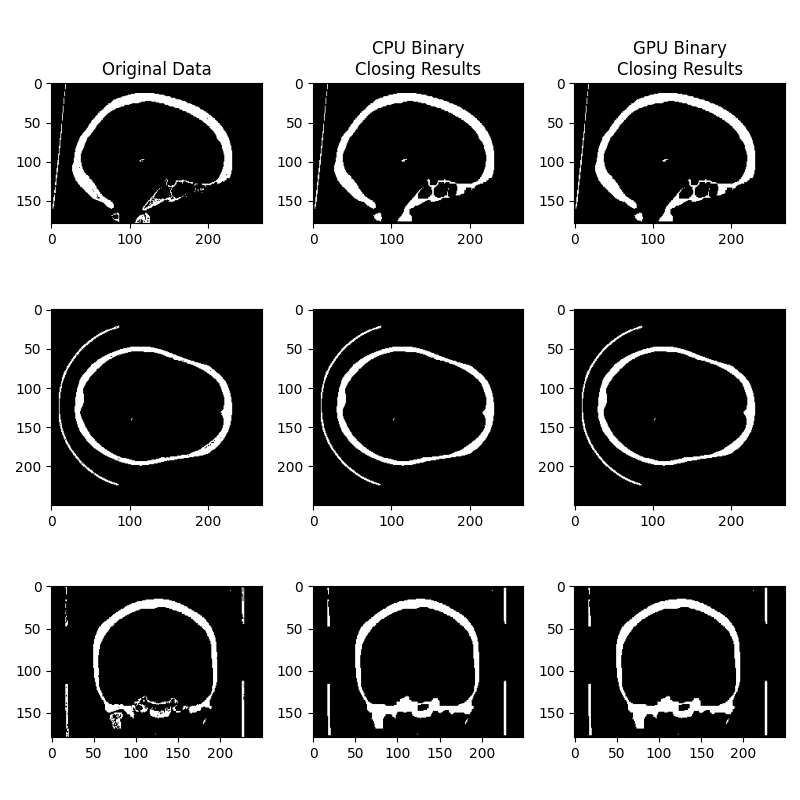

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

slice_num = resampled_data.shape[0]//2
axs[0,0].set_title("Original Data")
axs[0,0].imshow(np.rot90(fct[slice_num,:,:]), cmap='gray')
axs[0,1].set_title("CPU Binary\nClosing Results")
axs[0,1].imshow(np.rot90(data_binary_closing_cpu[slice_num,:,:]), cmap='gray')
axs[0,2].set_title("GPU Binary\nClosing Results")
axs[0,2].imshow(np.rot90(data_binary_closing_gpu[slice_num,:,:]), cmap='gray')

slice_num = resampled_data.shape[2]//2
axs[1,0].imshow(fct[:,:,slice_num], cmap='gray')
axs[1,1].imshow(data_binary_closing_cpu[:,:,slice_num], cmap='gray')
axs[1,2].imshow(data_binary_closing_gpu[:,:,slice_num], cmap='gray')

slice_num = resampled_data.shape[1]//2
axs[2,0].imshow(np.rot90(fct[:,slice_num,:]), cmap='gray')
axs[2,1].imshow(np.rot90(data_binary_closing_cpu[:,slice_num,:]), cmap='gray')
axs[2,2].imshow(np.rot90(data_binary_closing_gpu[:,slice_num,:]), cmap='gray')

# Adjust plots
plt.subplots_adjust(top=0.8,bottom=0.2,wspace=0.1, hspace=0)
plt.tight_layout()

### Check Output Data Matches Truth Data

In [9]:
data_match = np.all(data_binary_closing_cpu==data_binary_closing_gpu)
print(f"Data matches? {data_match}")

if not data_match:
    # DICE coefficient calculation
    matches = abs(data_binary_closing_gpu - data_binary_closing_cpu) < 1e-6
    matches_count = len(matches[matches==True])
    dice_coeff = 2 * matches_count / (data_binary_closing_cpu.size + data_binary_closing_gpu.size)
    print(f"Dice Coefficient: {dice_coeff}")

    # Plot difference images
    diffs = abs(data_binary_closing_gpu - data_binary_closing_cpu)

    fig, axs = plt.subplots(3, 1, figsize=(4, 12))

    slice_num = diffs.shape[0]//2
    axs[0].imshow(np.rot90(diffs[slice_num,:,:]), cmap='gray')

    slice_num = diffs.shape[2]//2
    axs[1].imshow(diffs[:,:,slice_num], cmap='gray')

    slice_num = diffs.shape[1]//2
    axs[2].imshow(np.rot90(diffs[:,slice_num,:]), cmap='gray')

    plt.tight_layout()

    # Get difference histograms
    hist,bins = np.histogram(diffs)
    print(f"Difference Histogram")
    for bin in range(len(bins)-1):
        print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")

    # Mean square error calculation
    mse = mean_squared_error(data_binary_closing_cpu,data_binary_closing_gpu)
    print(f"Mean square error: {mse}")

    # Normalized root mean square error calculation
    nrmse = normalized_root_mse(data_binary_closing_cpu,data_binary_closing_gpu,normalization='min-max')
    print(f"Normalized root mean square error: {nrmse}")

Data matches? True
